In [1]:
%matplotlib inline
import plotting_Boyle as plt_B
reload(plt_B)
import matplotlib.pylab as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns
sns.set_style('ticks');
current_colors = sns.color_palette()
sns.set_palette('Accent');
import sys 
sys.path.append('../code_general/')
from read_model_ID import unpack_parameters
import CRISPR_free_energy_landscape as FreeEnergy
reload(FreeEnergy);
import plotting_Boyle as plt_B
reload(plt_B)
import CRISPR_dCas9_binding_curve_Boyle as dCas9
reload(dCas9);

import analysis_SA_fits as SAfits
reload(SAfits);



import Boyle_data_processing as Bdata
reload(Bdata);

import read_model_ID;
reload(read_model_ID);

# step 1: Use SA fit to association data from Boyle et al. 

Using simmulated annealing we minimise the $\chi^2$ based on the data with singly and doubly mismatched sequences.
Here we show our best fit.

In [2]:
simset = []
no_good = []

chi_squared = [] 

#---------- collect simulations ---------------
for sim in range(1,51) + range(101,151):
    sa = pd.read_csv('../data/25_10_2018/fit_25_10_2018_sim_' +str(sim)+'.txt', delimiter='\t', index_col=46)
    filename = '../data/25_10_2018/fit_25_10_2018_sim_' +str(sim) +'.txt'   
    chi_squared.append(sa.Potential.iloc[-1])
    simset.append(filename)
    
for sim in range(11,21):
    sa = pd.read_csv('../data/19_10_2018/fit_19_10_2018_sim_' +str(sim)+'.txt', delimiter='\t', index_col=46)
    filename = '../data/19_10_2018/fit_19_10_2018_sim_' +str(sim) +'.txt'
    chi_squared.append(sa.Potential.iloc[-1])
    simset.append(filename)
    
    
best_fit = simset[np.argmin(chi_squared)]

In [3]:
best_fit

'../data/25_10_2018/fit_25_10_2018_sim_22.txt'

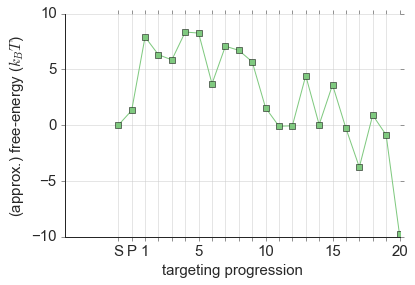

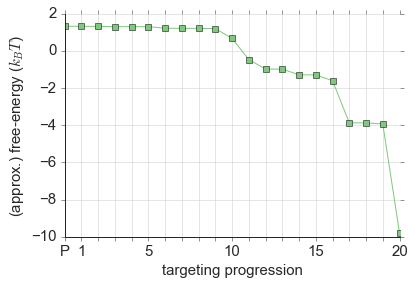

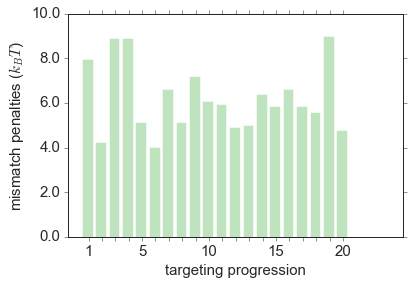

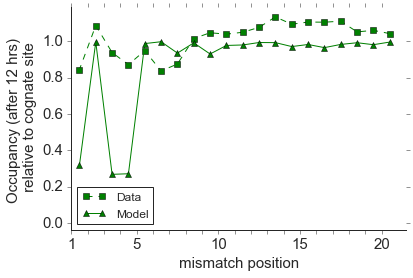

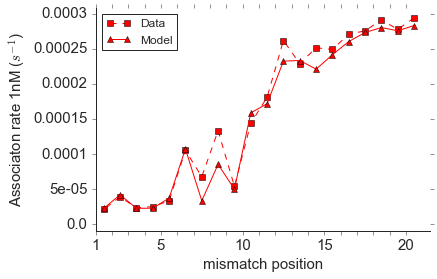

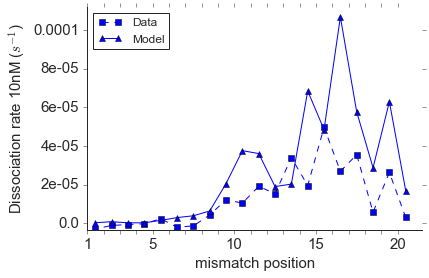

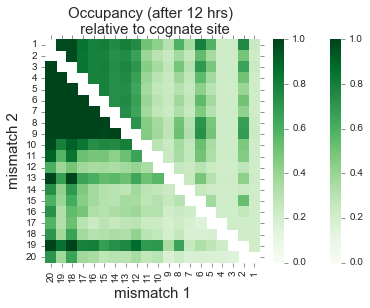

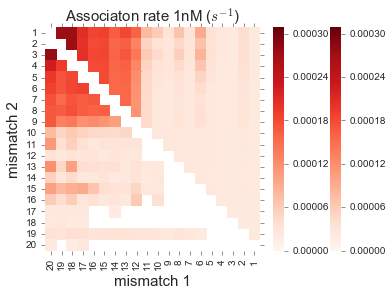

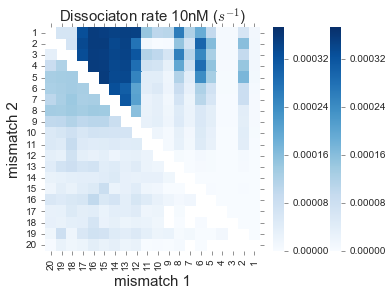

In [4]:
model_id = 'init_limit_general_energies_v2'
filename = best_fit
Nparams = 44
parameters = plt_B.load_simm_anneal(filename, Nparams)




Model_pbound, Model_on, Model_off = plt_B.calc_predictions(parameters,model_id)


Energy_landscape, FreeEnergy_landscape = FreeEnergy.plot_free_energy_landscape(parameters,model_id);

plt.figure()
FreeEnergy.plot_mismatch_penalties(parameters, model_id)


plt.figure()
_,_ = plt_B.plot_single_mismatches(Model_pbound ,kind='Occupancy')

plt.figure()
_,_ = plt_B.plot_single_mismatches(Model_on ,kind='OnRate')

plt.figure()
_,_ = plt_B.plot_single_mismatches(Model_off ,kind='OffRate')

plt.figure()
_,_ = plt_B.plot_heatmap(Model_pbound ,kind='Occupancy')

plt.figure()
_,_ = plt_B.plot_heatmap(Model_on ,kind='OnRate')

plt.figure()
_,_ = plt_B.plot_heatmap(Model_off ,kind='OffRate')


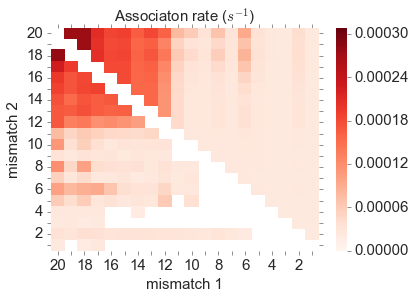

In [12]:
fldr_Boyle_data = '../Data_Boyle/KoenDataForMisha/BoyleData/'
colormap = 'Reds'
data_file = 'DataOnRate.txt'
title = r'Associaton rate ($s^{-1}$)'
experiment = np.loadtxt(delimiter=',' , fname=fldr_Boyle_data + data_file)
model = Model_on
val_min = 0
val_max_1 = np.nanmax(experiment)
val_max_2 = np.max(model)
val_max = np.max(np.array([val_max_1, val_max_2]))
val_max = (1+0.05)*val_max
mask_exp = np.zeros(shape=experiment.shape)
for i in range(len(experiment)):
    for j in range(i - 1, len(experiment)):
        mask_exp[i, j] = 1
ax = plt.gca()
sns.heatmap(experiment, cmap=colormap, mask=mask_exp, vmax=val_max, vmin=val_min, cbar=False)
mask = np.ones(shape=model.shape)
for i in range(len(model)):
    for j in range(i + 1, len(model)):
        mask[i, j] = 0
sns.heatmap(model, cmap=colormap, mask=mask, vmax=val_max, vmin=val_min, cbar=True)
plt.xticks(fontsize=15)
ax.set_xticklabels(['20','','18','','16','','14','','12','','10','','8','','6','','4','','2','']);
plt.yticks(fontsize=15)
ax.set_yticklabels(['20','','18','','16','','14','','12','','10','','8','','6','','4','','2','']);
ax.set_xlabel('mismatch 1', fontsize=15)
ax.set_ylabel('mismatch 2', fontsize=15)
ax.set_title(title, fontsize=15);
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=15)
plt.savefig('Onrate.pdf',bbox_inches='tight')

# step 2: How certain are we about each fitted parameter value? 

As we suspect we used more parameters than the number of degrees of freedom the data is able to pinpoint, we attempt to determine the robustness with which we can determine each fit parameter. 
To do such, we repeated our fits multiple times and kept those that predict association rates similar to the best fit. We say that if the 'Relative Difference in Predicted Values' (RDPV) is less than 5% (RDPV<0.05), the two fit results are equally good predictors of the data and are therefore equally vallid.

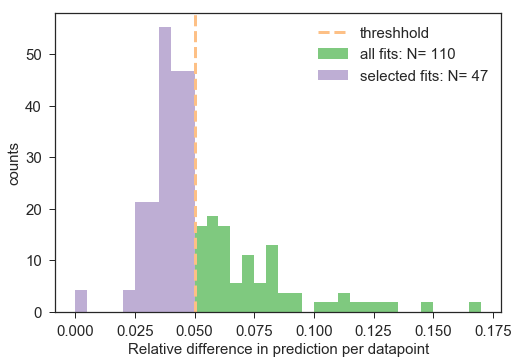

In [6]:
scores = np.loadtxt('../data/25_10_2018/select_with_predcitions.txt')
selected_sims, selected_scores, scores = SAfits.select_on_prediction(simset, 
                                                         chi_squared, 
                                                         percentage=0.05,
                                                         Nparams=44,
                                                         model_id='init_limit_general_energies_v2',
                                                         precalculated=True, 
                                                         score=scores,
                                                         save_scores=False, 
                                                         filename='../data/25_10_2018/select_with_predcitions.txt'
                                                         )
plt.hist(scores, normed=True, bins=np.arange(0,0.175,0.005), label='all fits: N= ' +str(len(scores)))
plt.hist(selected_scores,normed=True, bins=np.arange(0,0.175,0.005), label='selected fits: N= ' +str(len(selected_scores)));

plt.axvline(0.05, linestyle='dashed', linewidth=3, color=sns.color_palette()[2], label='threshhold')


plt.legend(fontsize=15);
plt.xlabel('Relative difference in prediction per datapoint', fontsize=15);
plt.ylabel('counts', fontsize=15);
plt.xticks(fontsize=15);

plt.yticks(fontsize=15);

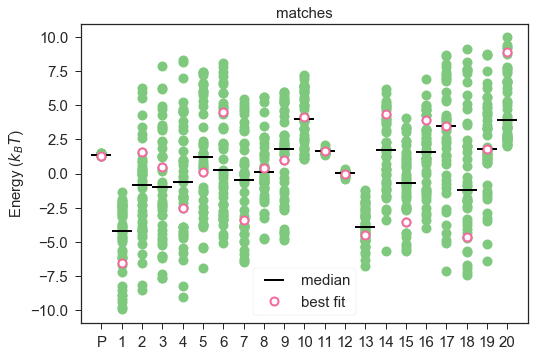

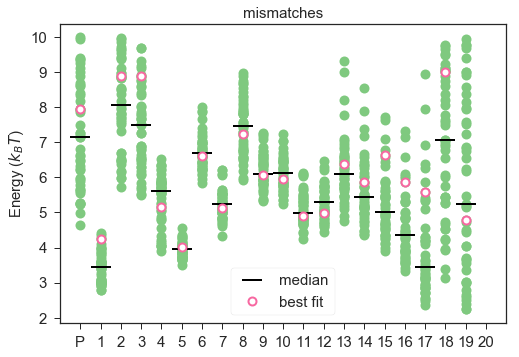

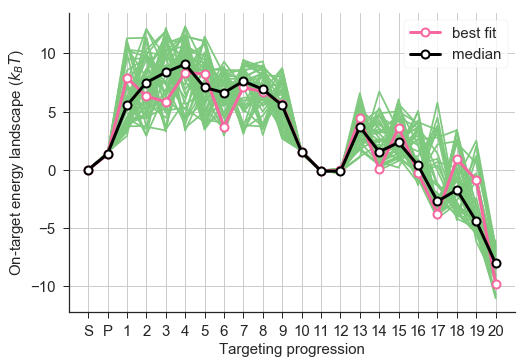

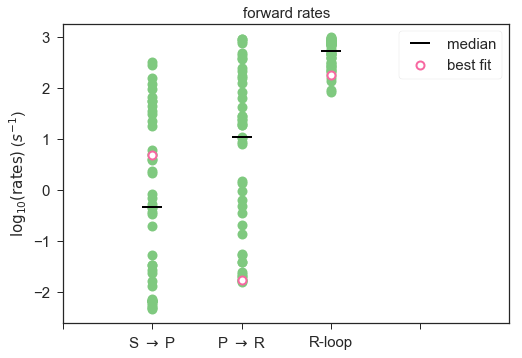

In [7]:
# --- make selection --- 
simset = selected_sims 

# --- store resulting fit parameters in a set of Dataframes --- 
matches, mismatches, rates, landscape, free_energy, fast_Rloop = SAfits.process_SA_fits(simset)
forward_rates = rates[['sol_to_PAM','PAM_to_R1','internal']]




# ---- show fluctuations in parameter sets --- 

# --- Matches ---
# MAYBE WE WANT TO NEGATE (multiply by -1 all the epsilonC to have the same sign convention as EpsilonPAM and EpsilonI)
plt.figure()
for sim in simset:
    matches.loc[sim].plot(marker='o',markersize=10,linestyle='', color=sns.color_palette()[0], alpha=1.0,label='')

matches.median().plot(color='black',
            linestyle='',
             marker='_', 
             lw=4,
             markersize =20,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='median')    

matches.loc[best_fit].plot(color='#f768a1',
            linestyle='',
             marker='o', 
             lw=3,
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='best fit')



plt.title('matches',fontsize=15)
plt.xticks(range(0,21),['P']+range(1,21),fontsize=15);
plt.xlim(-1,21);
plt.yticks(fontsize=15);
plt.ylabel('Energy ($k_BT$)',fontsize=15);
plt.legend(fontsize=15,frameon=True);

# --- Mismatches --- 
plt.figure()
for sim in simset:
    mismatches.loc[sim].plot(marker='o',markersize=10,linestyle='', color=sns.color_palette()[0], alpha=1.0,label='')

mismatches.median().plot(color='black',
            linestyle='',
             marker='_', 
             lw=4,
             markersize =20,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='median')    
    

mismatches.loc[best_fit].plot(color='#f768a1',
            linestyle='',
             marker='o', 
             lw=3,
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='best fit')



plt.title('mismatches',fontsize=15)
plt.xticks(range(0,21),['P']+range(1,21),fontsize=15);
plt.xlim(-1,21);
plt.yticks(fontsize=15);
plt.ylabel('Energy ($k_BT$)',fontsize=15);
plt.legend(fontsize=15,frameon=True);

# --- (microscopic) free-energy landscape --- 
plt.figure()
for filename in simset:
    parameters = plt_B.load_simm_anneal(filename, Nparams)
    Energy_landscape, FreeEnergy_landscape = FreeEnergy.plot_free_energy_landscape(parameters,model_id,show_plot=False);
    plt.plot(np.array(Energy_landscape),color=sns.color_palette()[0])
lowest_chi_squared = np.array( landscape.loc[best_fit] )

plt.plot(np.array(lowest_chi_squared), color='#f768a1' , 
             marker='o', 
             lw=3,
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='best fit');

LandscapeMED = landscape[landscape.columns[:]].median()
plt.plot(np.array(LandscapeMED),color='black' , 
             marker='o',
             lw=3,
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='median');

plt.legend(fontsize=15,frameon=True)
plt.xlim(-1,22)
plt.xticks(range(0,22),['S','P']+list(LandscapeMED.index[2:]),  fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('Targeting progression',fontsize=15)
plt.ylabel('On-target energy landscape ($k_BT$)',fontsize=15)
plt.grid('on')
sns.despine();


# --- 10log of the forward rates --- 
plt.figure()
for sim in simset:
    forward_rates.loc[sim].apply(np.log10).plot(marker='o',markersize=10,linestyle='', color=sns.color_palette()[0], alpha=1.0,label='')

forward_rates.median().apply(np.log10).plot(color='black',
            linestyle='',
             marker='_', 
             lw=4,
             markersize =20,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='median')    
    
    

forward_rates.loc[best_fit].apply(np.log10).plot(color='#f768a1',
            linestyle='',
             marker='o', 
             lw=3,
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='best fit')



plt.title('forward rates',fontsize=15)
plt.xticks(range(-1,4),['',r'S $\rightarrow$ P',r'P $\rightarrow$ R','R-loop',''],fontsize=15);
plt.xlim(-1,4);
plt.yticks(fontsize=15);
plt.ylabel(r'$\log_{10}(\rm{rates})$ ($s^{-1}$)',fontsize=15);
plt.legend(fontsize=15,frameon=True);




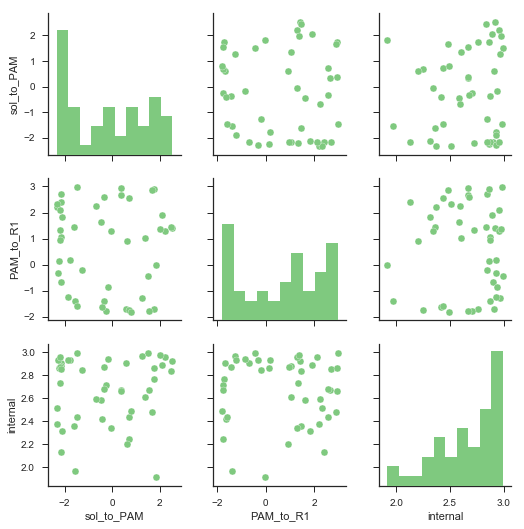

In [8]:
sns.pairplot(data=forward_rates.apply(np.log10));

# Step 3: Collapse on macroscopic physical quantities shows important parameters

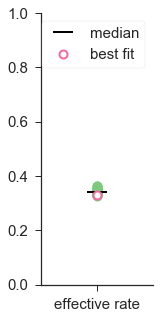

In [9]:
plt.figure(figsize=(2,5))
for sim in simset:
    plt.plot(fast_Rloop['kinetic'].loc[sim],
             marker='o',markersize=10,linestyle='', color=sns.color_palette()[0], alpha=1.0,label='')

plt.plot(fast_Rloop['kinetic'].median(),
         color='black',
            linestyle='',
             marker='_', 
             lw=4,
             markersize =20,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='median')    


plt.plot(fast_Rloop['kinetic'].loc[best_fit],
         color='#f768a1',
            linestyle='',
             marker='o', 
             lw=3,
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='best fit')



# plt.title('matches',fontsize=15)
plt.xticks([0],['effective rate'],fontsize=15);
plt.xlim(-0.01,0.01);
sns.despine()
plt.yticks(fontsize=15);
# plt.ylabel('Energy ($k_BT$)',fontsize=15);
plt.ylim(0.0,1.00)
plt.legend(fontsize=15,frameon=True);


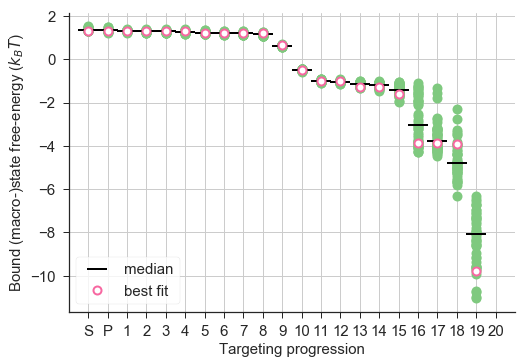

In [10]:
plt.figure()
for sim in simset:
    free_energy.loc[sim].plot(marker='o',markersize=10,linestyle='', color=sns.color_palette()[0], alpha=1.0,label='')

free_energy.median().plot(color='black',
            linestyle='',
             marker='_', 
             lw=4,
             markersize =20,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='median')    

free_energy.loc[best_fit].plot(color='#f768a1',
            linestyle='',
             marker='o', 
             lw=3,
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='best fit')


# plt.title('on-target bound free-energy (coarse-grained bound-unbound system)',fontsize=15);
plt.legend(fontsize=15,frameon=True,loc='lower left')
plt.xlim(-1,22)
plt.xticks(range(0,22),['S','P']+list(LandscapeMED.index[2:]),  fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('Targeting progression',fontsize=15)
plt.ylabel('Bound (macro-)state free-energy ($k_BT$)',fontsize=15)
plt.grid('on')
sns.despine();

# step 4: fix the energy landscape to the best fit and re-fit the rates 

In [29]:
reload(SAfits);

fix_to_best_fit = []
no_good = []

chi_squared = [] 

#---------- collect simulations ---------------
for sim in range(1,51):
    sa = pd.read_csv('../data/18_12_2018/fit_18_12_2018_sim_' +str(sim)+'.txt', delimiter='\t', index_col=5)
    filename = '../data/18_12_2018/fit_18_12_2018_sim_' +str(sim) +'.txt'   
    chi_squared.append(sa.Potential.iloc[-1])
    fix_to_best_fit.append(filename)
    

# --- store resulting fit parameters in a set of Dataframes --- 
matches, mismatches, rates, landscape, free_energy, fast_Rloop = SAfits.process_SA_fits(fix_to_best_fit,
                                                                                       Nparams=3,
                                                                                       model_id='landscape_lowest_chi_squared_fit_rates')
forward_rates = rates[['sol_to_PAM','PAM_to_R1','internal']]

# --- retrieve the best fit in this set --- 
fix_to_best_fit_best = fix_to_best_fit[np.argmin(chi_squared)]



# --- obtain distribution of differences in predicted values --- 
scores = np.loadtxt('../data/18_12_2018/select_with_predcitions.txt')
selected_sims, selected_scores, scores = SAfits.select_on_prediction(fix_to_best_fit, 
                                                         chi_squared, 
                                                         percentage=1.0,
                                                         Nparams=3,
                                                         model_id='landscape_lowest_chi_squared_fit_rates',
                                                         precalculated=True, 
                                                         score=scores,
                                                         save_scores=False, 
                                                         filename='../data/18_12_2018/select_with_predcitions.txt'
                                                         )

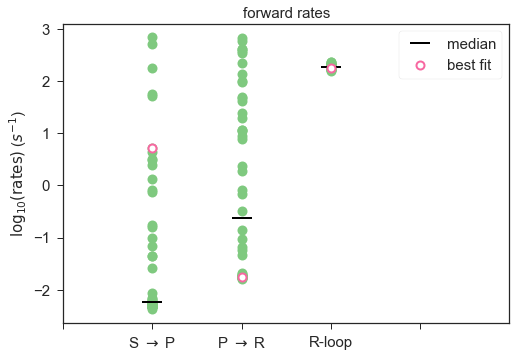

In [11]:
# --- 10log of the forward rates --- 
plt.figure()
for sim in fix_to_best_fit:
    forward_rates.loc[sim].apply(np.log10).plot(marker='o',markersize=10,linestyle='', color=sns.color_palette()[0], alpha=1.0,label='')

forward_rates.median().apply(np.log10).plot(color='black',
            linestyle='',
             marker='_', 
             lw=4,
             markersize =20,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='median')    
    
    

forward_rates.loc[fix_to_best_fit_best].apply(np.log10).plot(color='#f768a1',
            linestyle='',
             marker='o', 
             lw=3,
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='best fit')



plt.title('forward rates',fontsize=15)
plt.xticks(range(-1,4),['',r'S $\rightarrow$ P',r'P $\rightarrow$ R','R-loop',''],fontsize=15);
plt.xlim(-1,4);
plt.yticks(fontsize=15);
plt.ylabel(r'$\log_{10}(\rm{rates})$ ($s^{-1}$)',fontsize=15);
plt.legend(fontsize=15,frameon=True);

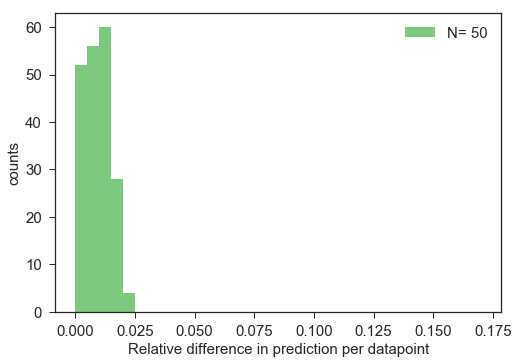

In [12]:
plt.hist(scores, normed=True, bins=np.arange(0,0.175,0.005), label='N= ' +str(len(scores)))
# plt.axvline(0.05, linestyle='dashed', linewidth=3, color=sns.color_palette()[2], label='threshhold')


plt.legend(fontsize=15);
plt.xlabel('Relative difference in prediction per datapoint', fontsize=15);
plt.ylabel('counts', fontsize=15);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

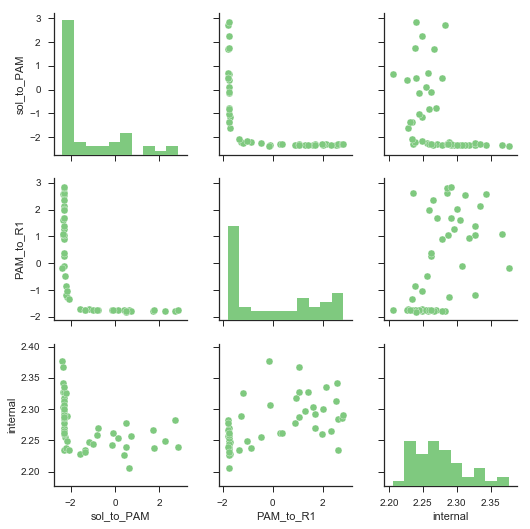

In [13]:
sns.pairplot(data=forward_rates.apply(np.log10));

# step 5: fix the landscape to be the median landscape and re-fit the rates 

In [14]:
fix_to_median = []
no_good = []

chi_squared = [] 

#---------- collect simulations ---------------
for sim in range(101,151):
    sa = pd.read_csv('../data/4_12_2018/fit_4_12_2018_sim_' +str(sim)+'.txt', delimiter='\t', index_col=5)
    filename = '../data/4_12_2018/fit_4_12_2018_sim_' +str(sim) +'.txt'   
    chi_squared.append(sa.Potential.iloc[-1])
    fix_to_median.append(filename)
    

# --- store resulting fit parameters in a set of Dataframes --- 
matches, mismatches, rates, landscape, free_energy, fast_Rloop = SAfits.process_SA_fits(fix_to_median,
                                                                                       Nparams=3,
                                                                                       model_id='landscape_lowest_chi_squared_fit_rates')
forward_rates = rates[['sol_to_PAM','PAM_to_R1','internal']]


# --- retrieve the best fit in this set --- 
fix_to_median_best = fix_to_median[np.argmin(chi_squared)]

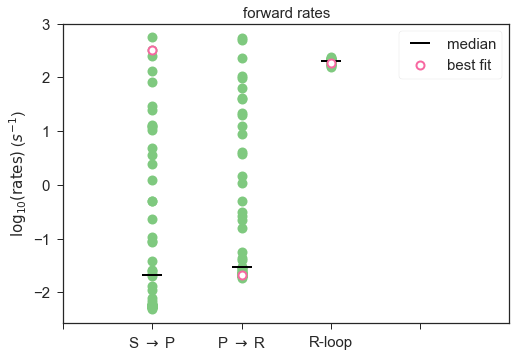

In [15]:
# --- 10log of the forward rates --- 
plt.figure()
for sim in fix_to_median:
    forward_rates.loc[sim].apply(np.log10).plot(marker='o',markersize=10,linestyle='', color=sns.color_palette()[0], alpha=1.0,label='')

forward_rates.median().apply(np.log10).plot(color='black',
            linestyle='',
             marker='_', 
             lw=4,
             markersize =20,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='median')    
    
    

forward_rates.loc[fix_to_median_best].apply(np.log10).plot(color='#f768a1',
            linestyle='',
             marker='o', 
             lw=3,
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='best fit')



plt.title('forward rates',fontsize=15)
plt.xticks(range(-1,4),['',r'S $\rightarrow$ P',r'P $\rightarrow$ R','R-loop',''],fontsize=15);
plt.xlim(-1,4);
plt.yticks(fontsize=15);
plt.ylabel(r'$\log_{10}(\rm{rates})$ ($s^{-1}$)',fontsize=15);
plt.legend(fontsize=15,frameon=True);

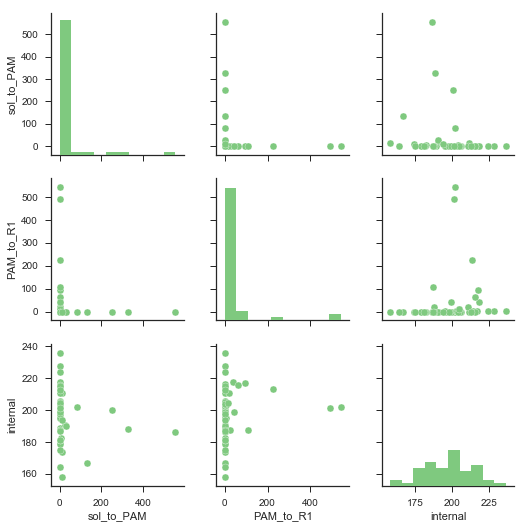

In [16]:
sns.pairplot(data=forward_rates);

# step 6: Correlation between best fit and training data ($<3$ mm )  and testing data ($>2$ mm)

In [17]:
replica='1'
path='../Data_Boyle/'
filename = best_fit
Nparams = 44
parameters = plt_B.load_simm_anneal(filename, Nparams)
model_id = 'init_limit_general_energies_v2'

data = pd.read_csv(path + 'second_fit_data.summarized.on.1nM.rep' + str(replica) + '.txt', delimiter='\t')
data['MM_pos'] = data['mutations'].apply(Bdata.get_pos)


#---- filter out the PAM mutations ---- 
data['PAM_mutant']= data['MM_pos'].apply(Bdata.find_PAM_mutations)
data = data[data.PAM_mutant==False]


data['model prediction'] = data['MM_pos'].apply(lambda x: dCas9.calc_Boyle(mismatch_positions=[x], 
                                                CalcOccupancy=False, 
                                                CalcOffRate=False, 
                                                CalcOnRate=True, 
                                                parameters=parameters, 
                                                guide_length=20, 
                                                model_id=model_id))
model_predictions = []
for i in data.index:
    model_predictions.append( data['model prediction'][i][1] )
data['model prediction'] = model_predictions


more_than_two_mismatches = data[data.nmut>2]
up_to_two_mismatches = data[data.nmut<3]

In [18]:
_, Model_on, _ = plt_B.calc_predictions(parameters,model_id)
model_two_mm,experiment_two_mm = plt_B.plot_heatmap(Model_on, kind='OnRate',show_plot=False)

model_one_mm, experiment_one_mm = plt_B.plot_single_mismatches(Model_on, kind='OnRate',show_plot=False)

/Users/mklein1/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/mklein1/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/mklein1/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.o

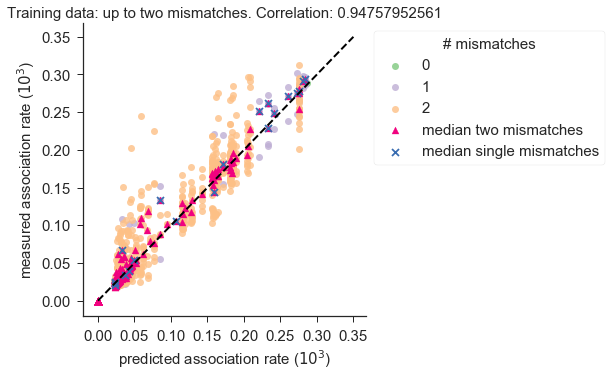

In [19]:
up_to_two_mismatches['predicted association rate'] = up_to_two_mismatches['model prediction'].apply(lambda x: 1000*x)
up_to_two_mismatches['measured association rate'] = up_to_two_mismatches['slope'].apply(lambda x: 1000*x)
# up_to_two_mismatches['# mutations'] = up_to_two_mismatches['nmut']

up_to_two_mismatches.rename(index=str, columns={"nmut": "# mutations"},inplace=True)

sns.lmplot(x='predicted association rate',
           y='measured association rate', 
           data=up_to_two_mismatches, 
           hue='# mutations',
           fit_reg=False,legend=False)

plt.scatter(np.triu(model_two_mm)*1000, np.triu(experiment_two_mm)*1000, 
            marker='^',
            color=sns.color_palette()[5],
            label='median two mismatches')

plt.scatter(model_one_mm*1000, experiment_one_mm*1000,
            marker='x',
            color=sns.color_palette()[4],
            label='median single mismatches')



corrcoef = np.corrcoef(up_to_two_mismatches['predicted association rate'], 
                       up_to_two_mismatches['measured association rate'])[0][1]


plt.xlabel('predicted association rate ($10^{3}$)', fontsize=15);
plt.ylabel('measured association rate ($10^{3}$)', fontsize=15);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
lg = plt.legend(fontsize=15, frameon=True, 
                title='# mismatches',bbox_to_anchor=(1.0,1.0));
title = lg.get_title()
title.set_fontsize(15)
plt.title('Training data: up to two mismatches. Correlation: '+ str(corrcoef), fontsize=15);



x = np.linspace(0,0.35, 1000)
plt.plot(x,x, linestyle='dashed',color='black',linewidth=2);


/Users/mklein1/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/mklein1/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/mklein1/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

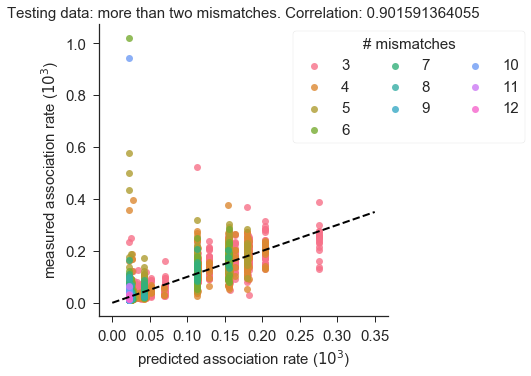

In [20]:
more_than_two_mismatches['predicted association rate'] = more_than_two_mismatches['model prediction'].apply(lambda x: 1000*x)
more_than_two_mismatches['measured association rate'] = more_than_two_mismatches['slope'].apply(lambda x: 1000*x)
more_than_two_mismatches['# mutations'] = more_than_two_mismatches['nmut']
sns.lmplot(x='predicted association rate',
           y='measured association rate', 
           data=more_than_two_mismatches, 
           hue='# mutations',
           fit_reg=False,legend=False,
       )

corrcoef = np.corrcoef(more_than_two_mismatches['predicted association rate'], 
                       more_than_two_mismatches['measured association rate'])[0][1]




plt.xlabel('predicted association rate ($10^{3}$)', fontsize=15);
plt.ylabel('measured association rate ($10^{3}$)', fontsize=15);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
lg = plt.legend(fontsize=15, frameon=True,title='# mismatches', 
                ncol=3,
               bbox_to_anchor=(1.5,1.0));
title = lg.get_title()
title.set_fontsize(15)

plt.title('Testing data: more than two mismatches. Correlation: '+str(corrcoef), fontsize=15);

x = np.linspace(0,0.35, 1000)
plt.plot(x,x, linestyle='dashed',color='black',linewidth=2);

# step 7: Correlation between model and data using median energy landscape

In [21]:
replica='1'
path='../Data_Boyle/'
filename =fix_to_median_best
Nparams = 3
parameters = plt_B.load_simm_anneal(filename, Nparams)
model_id = 'Boyle_median_landscape_fit_rates'

data = pd.read_csv(path + 'second_fit_data.summarized.on.1nM.rep' + str(replica) + '.txt', delimiter='\t')
data['MM_pos'] = data['mutations'].apply(Bdata.get_pos)


#---- filter out the PAM mutations ---- 
data['PAM_mutant']= data['MM_pos'].apply(Bdata.find_PAM_mutations)
data = data[data.PAM_mutant==False]


data['model prediction'] = data['MM_pos'].apply(lambda x: dCas9.calc_Boyle(mismatch_positions=[x], 
                                                CalcOccupancy=False, 
                                                CalcOffRate=False, 
                                                CalcOnRate=True, 
                                                parameters=parameters, 
                                                guide_length=20, 
                                                model_id=model_id))
model_predictions = []
for i in data.index:
    model_predictions.append( data['model prediction'][i][1] )
data['model prediction'] = model_predictions


more_than_two_mismatches = data[data.nmut>2]
up_to_two_mismatches = data[data.nmut<3]

/Users/mklein1/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/mklein1/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


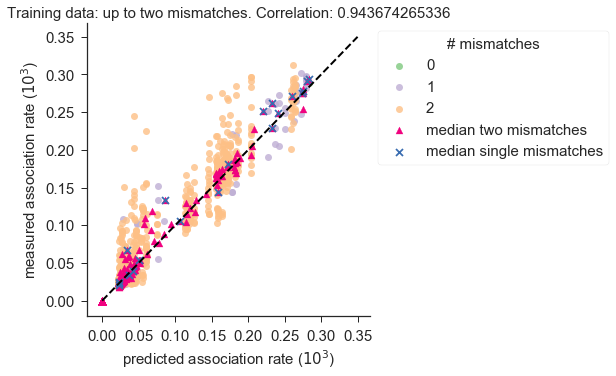

In [22]:
up_to_two_mismatches['predicted association rate'] = up_to_two_mismatches['model prediction'].apply(lambda x: 1000*x)
up_to_two_mismatches['measured association rate'] = up_to_two_mismatches['slope'].apply(lambda x: 1000*x)
# up_to_two_mismatches['# mutations'] = up_to_two_mismatches['nmut']

up_to_two_mismatches.rename(index=str, columns={"nmut": "# mutations"},inplace=True)

sns.lmplot(x='predicted association rate',
           y='measured association rate', 
           data=up_to_two_mismatches, 
           hue='# mutations',
           fit_reg=False,legend=False)

plt.scatter(np.triu(model_two_mm)*1000, np.triu(experiment_two_mm)*1000, 
            marker='^',
            color=sns.color_palette()[5],
            label='median two mismatches')

plt.scatter(model_one_mm*1000, experiment_one_mm*1000,
            marker='x',
            color=sns.color_palette()[4],
            label='median single mismatches')



corrcoef = np.corrcoef(up_to_two_mismatches['predicted association rate'], 
                       up_to_two_mismatches['measured association rate'])[0][1]


plt.xlabel('predicted association rate ($10^{3}$)', fontsize=15);
plt.ylabel('measured association rate ($10^{3}$)', fontsize=15);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
lg = plt.legend(fontsize=15, frameon=True, 
                title='# mismatches',bbox_to_anchor=(1.0,1.0));
title = lg.get_title()
title.set_fontsize(15)
plt.title('Training data: up to two mismatches. Correlation: '+ str(corrcoef), fontsize=15);



x = np.linspace(0,0.35, 1000)
plt.plot(x,x, linestyle='dashed',color='black',linewidth=2);


/Users/mklein1/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/mklein1/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/mklein1/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

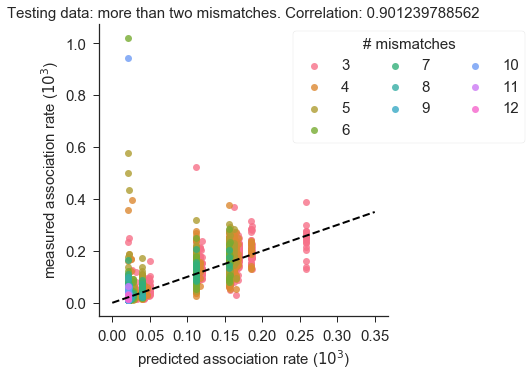

In [23]:
more_than_two_mismatches['predicted association rate'] = more_than_two_mismatches['model prediction'].apply(lambda x: 1000*x)
more_than_two_mismatches['measured association rate'] = more_than_two_mismatches['slope'].apply(lambda x: 1000*x)
more_than_two_mismatches['# mutations'] = more_than_two_mismatches['nmut']
sns.lmplot(x='predicted association rate',
           y='measured association rate', 
           data=more_than_two_mismatches, 
           hue='# mutations',
           fit_reg=False,legend=False,
       )

corrcoef = np.corrcoef(more_than_two_mismatches['predicted association rate'], 
                       more_than_two_mismatches['measured association rate'])[0][1]




plt.xlabel('predicted association rate ($10^{3}$)', fontsize=15);
plt.ylabel('measured association rate ($10^{3}$)', fontsize=15);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
lg = plt.legend(fontsize=15, frameon=True,title='# mismatches', 
                ncol=3,
               bbox_to_anchor=(1.5,1.0));
title = lg.get_title()
title.set_fontsize(15)

plt.title('Testing data: more than two mismatches. Correlation: '+str(corrcoef), fontsize=15);

x = np.linspace(0,0.35, 1000)
plt.plot(x,x, linestyle='dashed',color='black',linewidth=2);

# step 8: correlation between model predictions 

In [24]:
replica='1'
path='../Data_Boyle/'
filename =fix_to_median_best
Nparams = 3
parameters = plt_B.load_simm_anneal(filename, Nparams)
model_id = 'Boyle_median_landscape_fit_rates'

data = pd.read_csv(path + 'second_fit_data.summarized.on.1nM.rep' + str(replica) + '.txt', delimiter='\t')
data['MM_pos'] = data['mutations'].apply(Bdata.get_pos)


#---- filter out the PAM mutations ---- 
data['PAM_mutant']= data['MM_pos'].apply(Bdata.find_PAM_mutations)
data = data[data.PAM_mutant==False]


# --- calculate 1st model ---- 
data['median landscape'] = data['MM_pos'].apply(lambda x: dCas9.calc_Boyle(mismatch_positions=[x], 
                                                CalcOccupancy=False, 
                                                CalcOffRate=False, 
                                                CalcOnRate=True, 
                                                parameters=parameters, 
                                                guide_length=20, 
                                                model_id=model_id))
model_predictions = []
for i in data.index:
    model_predictions.append( data['median landscape'][i][1] )
data['median landscape'] = model_predictions


more_than_two_mismatches = data[data.nmut>2]
up_to_two_mismatches = data[data.nmut<3]



# --- calculate 2nd model ---- 

replica='1'
path='../Data_Boyle/'
filename = best_fit
Nparams = 44
parameters = plt_B.load_simm_anneal(filename, Nparams)
model_id = 'init_limit_general_energies_v2'


data['lowest $\chi^2$'] = data['MM_pos'].apply(lambda x: dCas9.calc_Boyle(mismatch_positions=[x], 
                                                CalcOccupancy=False, 
                                                CalcOffRate=False, 
                                                CalcOnRate=True, 
                                                parameters=parameters, 
                                                guide_length=20, 
                                                model_id=model_id))
model_predictions = []
for i in data.index:
    model_predictions.append( data['lowest $\chi^2$'][i][1] )
data['lowest $\chi^2$'] = model_predictions


more_than_two_mismatches = data[data.nmut>2]
up_to_two_mismatches = data[data.nmut<3]



data['lowest $\\chi^2$'] *=1000
data['median landscape'] *=1000
data['# mutations'] = data['nmut']

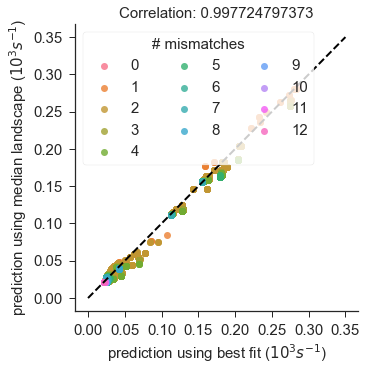

In [25]:



sns.lmplot(x='lowest $\chi^2$',
           y='median landscape', 
           data=data, 
           hue='# mutations',
           fit_reg=False,legend=False);


corrcoef = np.corrcoef(data['median landscape'], 
                       data['lowest $\\chi^2$'])[0][1]

plt.title('Correlation: '+str(corrcoef), fontsize=15);
plt.xlabel('prediction using best fit ($10^{3} s^{-1}$)',fontsize=15);
plt.ylabel('prediction using median landscape ($10^{3} s^{-1}$)',fontsize=15);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
lg = plt.legend(fontsize=15, frameon=True,title='# mismatches', 
                ncol=3,
               loc='best');
title = lg.get_title()
title.set_fontsize(15)


x = np.linspace(0,0.35, 1000)
plt.plot(x,x, linestyle='dashed',color='black',linewidth=2);




In [26]:
replica='1'
path='../Data_Boyle/'
filename = best_fit
Nparams = 44
parameters = plt_B.load_simm_anneal(filename, Nparams)
model_id = 'init_limit_general_energies_v2'
_, model_best, _ = plt_B.calc_predictions(parameters=parameters, model_id=model_id)


replica='1'
path='../Data_Boyle/'
filename =fix_to_median_best
Nparams = 3
parameters = plt_B.load_simm_anneal(filename, Nparams)
model_id = 'Boyle_median_landscape_fit_rates'
_, model_median, _ = plt_B.calc_predictions(parameters, model_id)

diff = SAfits.difference_model_predictions(model_median,model_best)
print diff 

0.0739985021693


# step 9: Compare best fit to CHAMP data Finkelstein lab 

Ilya showed us that Boyle's data correlates well with his. This indeed implies that simply assuming a linear relation between them could serve as a decent predictor of Ilya's data based on Boyle's. However, the point to be made here is that we actually model both datasets and get the absolute values correct without adjusting the model. 

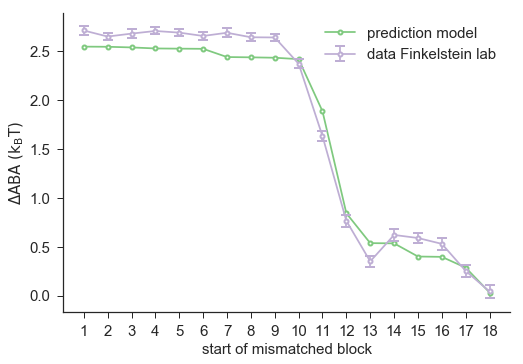

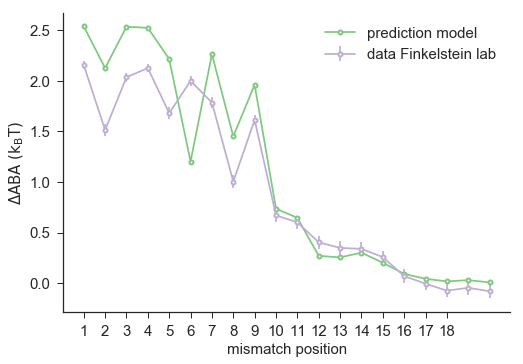

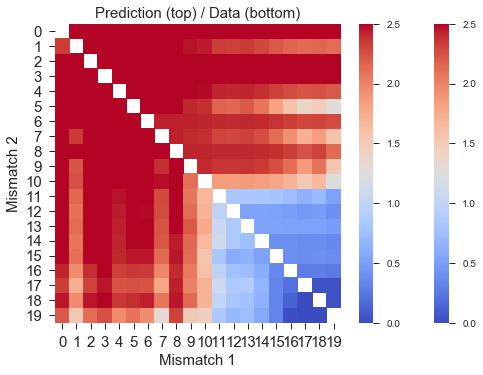

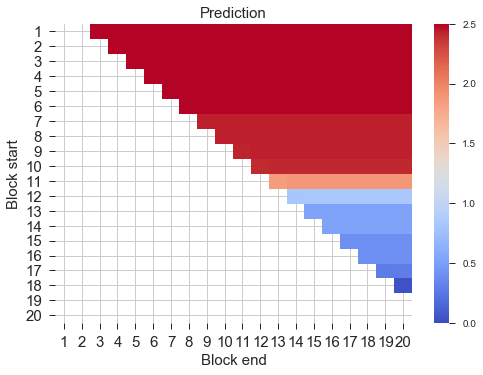

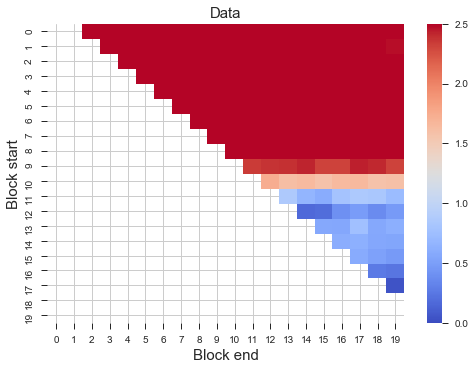

In [27]:
sys.path.append('../code_ABA_Finkelsteinlab/')
import plotting_ABA as pltABA
reload(pltABA);

# ---- load parameters ----- 
model_id = 'init_limit_general_energies_v2'
filename = best_fit
Nparams = 44
boyle_params = plt_B.load_simm_anneal(filename, Nparams)

# ---- load CHAMP data ------
IlyaData = pd.read_csv('../Data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/cas9-target-e-replicate-1-delta-abas-processed.csv')

# ---- plot comparissons ----- 
plt.figure()
_ = pltABA.predict_1D_mmblocks(boyle_params, model_id, T=60*10,guide_length=20);
plt.savefig('../reports/Skype_call_Ilya_10_12_2018/blocks_collapse_first_position.pdf', format='pdf',bbox_inches='tight')



plt.figure()
_ = pltABA.predict_single_mm(boyle_params,model_id)
plt.savefig('../reports/Skype_call_Ilya_10_12_2018/single_mm.pdf', format='pdf',bbox_inches='tight')


plt.figure()
_ = pltABA.predict_double_mm(boyle_params,model_id)
plt.savefig('../reports/Skype_call_Ilya_10_12_2018/double_mm_heatmap.pdf', format='pdf',bbox_inches='tight')


plt.figure()
_ = pltABA.predict_block_mismatches(parameters=boyle_params, model_id=model_id, T=60*10,guide_length=20)

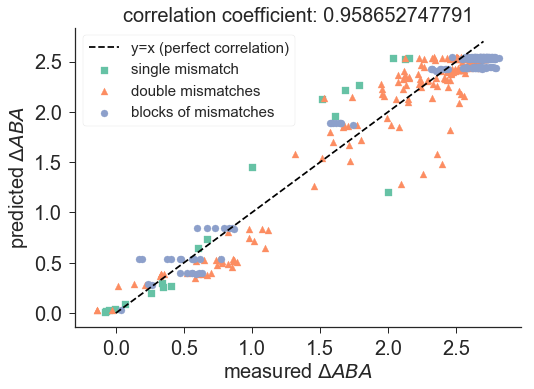

In [28]:
#########################################
# -----   Correlation plot ------------ #
#########################################


# --- data ---
data_1mm= pltABA.plot_single_mut_ABA(data=IlyaData, Mut_type='r', Plot=False)
_, data_2mm = pltABA.plot_double_mut_ABA(data=IlyaData, Mut_type='r', Plot=False)
_, data_blocks, _ = pltABA.plot_block_mm_ABA(IlyaData,Plot=False,SaveFigures=False,figure_names=[''])



#--- model predictions ---- 

model_1mm = pltABA.predict_single_mm(boyle_params,model_id, show_plot=False)
model_2mm = pltABA.predict_double_mm(boyle_params,model_id, show_plot=False)
model_blocks = pltABA.predict_block_mismatches(parameters=boyle_params, model_id=model_id, 
                                               T=60*10,guide_length=20,show_plot=False)



# --- collect all the datapoints ---
data = []
model = []
correlate_ABA = pd.DataFrame()
# --- 2 mismatches ----
for i in range(20):
    for j in range(20):
        if np.isnan(data_2mm[j,i])==False:
            data.append( data_2mm[j,i])
            model.append(model_2mm[j,i])
            
# --- blocks of mismatches -----       
for i in range(20):
    for j in range(20):
        if np.isnan(data_blocks[i,j])==False:
            data.append( data_2mm[j,i])
            model.append(model_2mm[j,i])

# --- single mismatches ----           
data_1mm_array = np.array(data_1mm['Delta ABA (kBT)'])
for i in range(len(data_1mm)):
    data.append(data_1mm_array[i])
    model.append(model_1mm[i])
    
correlate_ABA['data'] = data
correlate_ABA['model'] = model 
x = np.linspace(np.min(data),np.max(data),100)
C = np.corrcoef(data,model)[1][0]


# --- make the plot ----- 
sns.set_palette('Set2')
plt.scatter(data_1mm['Delta ABA (kBT)'],model_1mm, 
            marker='s',
            label='single mismatch')
plt.scatter(data_2mm,model_2mm, 
            marker='^',
            label='double mismatches')
plt.scatter(data_blocks,model_blocks, label='blocks of mismatches');

x = np.linspace(0,2.7,1000);
plt.plot(x,x, linestyle='dashed', color='black', label='y=x (perfect correlation)')
plt.legend(fontsize=15, frameon=True)
plt.xlabel('measured $\Delta ABA$',fontsize=20);
plt.ylabel('predicted $\Delta ABA$',fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
sns.despine();

C = np.corrcoef(data,model)[1,0]
plt.title('correlation coefficient: ' + str(C) , fontsize=20);

# plt.savefig('../reports/Skype_call_Ilya_10_12_2018/correlation_plot.pdf',format='pdf',bbox_inches='tight');

# Step 10: Can CHAMP data help discriminate what rates we need to choose? 

Probably not and we have shown that these values are indeed pretty much undetermined. This is no longer a problem of our fitting, simply a limitation of the information contained by the data. 

In [29]:
def difference_in_prediction_ABA(simset,ref_mm, ref_blocks,model_id='landscape_lowest_chi_squared_fit_rates',
                                 Nparams=3,
                                 filename='../data/18_12_2018/difference_prediction_ABA.txt',
                                save_results=True,
                                precalculated=False):
    
    

    
    # --- for every parameter set ----
    if not precalculated:
        Nblocks = 171.
        Nmm = 210. 
        ref_mm = SAfits.replace_lower_triangle(ref_mm)
        ref_blocks[np.isnan(ref_blocks)] = 1.0 
        diff = [] 
        for sim in simset:
            
            # ---- score for the mismatches (single + double) ----
            parameters = plt_B.load_simm_anneal(sim, Nparams)
            model_mm = pltABA.predict_double_mm(parameters,model_id, show_plot=False)
            model_mm = SAfits.replace_lower_triangle(model_mm)
            sum_difference = np.sum(np.abs(model_mm - ref_mm) / (ref_mm))
            diff_mm = sum_difference/Nmm
            
            # ---- score for the blocks ----
            model_blocks = pltABA.predict_block_mismatches(parameters=parameters, model_id=model_id, 
                                                   T=60*10,guide_length=20,show_plot=False)
            model_blocks[np.isnan(model_blocks)] = 1.0 
            sum_difference = np.sum(np.abs(model_blocks - ref_blocks) / (ref_blocks))
            diff_blocks = sum_difference/Nblocks
            
            # ----- Add together the scores ------ 
            diff.append(diff_mm *Nmm/(Nmm + Nblocks)  + diff_blocks *Nblocks/(Nmm + Nblocks))
        
        
        if save_results: 
            np.savetxt(filename,diff)
    else: 
        diff = np.loadtxt(filename)
    return np.array(diff)

In [30]:
ref_mm = model_2mm.copy()
ref_blocks = model_blocks.copy()


scoresABA = difference_in_prediction_ABA(fix_to_best_fit,ref_mm, ref_blocks,model_id='landscape_lowest_chi_squared_fit_rates',
                                 Nparams=3,
                                 filename='../data/18_12_2018/difference_prediction_ABA.txt',
                                save_results=False,
                                precalculated=True)

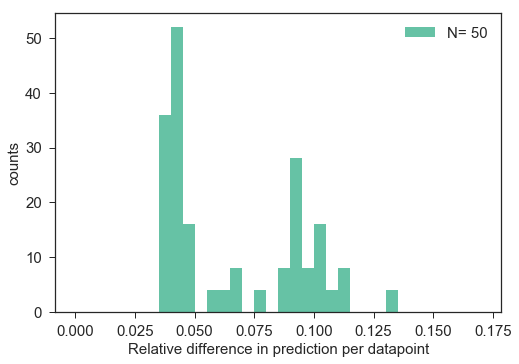

In [31]:
plt.hist(scoresABA, normed=True, bins=np.arange(0,0.175,0.005), label='N= ' +str(len(scores)))
plt.legend(fontsize=15);
plt.xlabel('Relative difference in prediction per datapoint', fontsize=15);
plt.ylabel('counts', fontsize=15);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

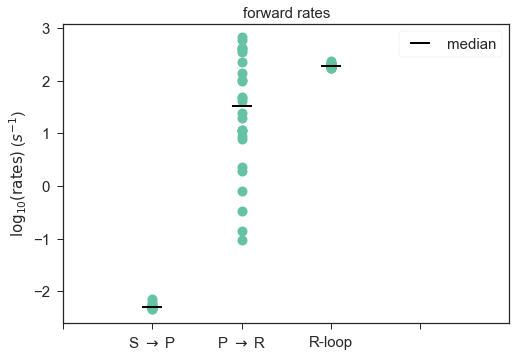

In [52]:

# --- select those fits with RPD<0.05 on ABA (test data) ---- 
fix_to_best_fit = np.array(fix_to_best_fit)
selection_after_ABA =  fix_to_best_fit[scoresABA<0.05]

# --- store resulting fit parameters in a set of Dataframes --- 
matches, mismatches, rates, landscape, free_energy, fast_Rloop = SAfits.process_SA_fits(selection_after_ABA,
                                                                                       Nparams=3,
                                                                                       model_id='landscape_lowest_chi_squared_fit_rates')
forward_rates = rates[['sol_to_PAM','PAM_to_R1','internal']]

# --- 10log of the forward rates --- 
plt.figure()
for sim in selection_after_ABA:
    forward_rates.loc[sim].apply(np.log10).plot(marker='o',markersize=10,linestyle='', color=sns.color_palette()[0], alpha=1.0,label='')

forward_rates.median().apply(np.log10).plot(color='black',
            linestyle='',
             marker='_', 
             lw=4,
             markersize =20,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='median')    
    
    

# forward_rates.loc[fix_to_best_fit_best].apply(np.log10).plot(color='#f768a1',
#             linestyle='',
#              marker='o', 
#              lw=3,
#              markersize =8,
#              markerfacecolor='white',
#              markeredgewidth= 2,
#         label='best fit')



plt.title('forward rates',fontsize=15)
plt.xticks(range(-1,4),['',r'S $\rightarrow$ P',r'P $\rightarrow$ R','R-loop',''],fontsize=15);
plt.xlim(-1,4);
plt.yticks(fontsize=15);
plt.ylabel(r'$\log_{10}(\rm{rates})$ ($s^{-1}$)',fontsize=15);
plt.legend(fontsize=15,frameon=True);